In [2]:
import csv, math, os
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3 as lite
conn = lite.connect('/Users/b/Library/Containers/com.hesterlab.smartppe.facebit-app/Data/Documents/db.sqlite')

In [2]:
def plot(df, event_id):
    pressure = df.where(df['type'] == 'pressure')
    temp = df.where(df['type'] == 'temperature')

    f, axarr = plt.subplots(2, figsize=(12,12), sharex=True)

    ax1 = sns.lineplot(
        x='date',
        y='value',
        data=pressure,
        color='r',
        label='pressure',
        ax=axarr[0]
    )
    ax1.set_title(f'Event {event_id}: Pressure')
    ax1.set_ylabel("mBar")

    ax2 = sns.lineplot(
        x='date',
        y='value',
        data=temp,
        color='b',
        label='temperature',
        ax=axarr[1]
    )
    ax2.set_title(f'Event {event_id}: Temperature')
    ax2.set_ylabel("Celsius")
    ax2.set_xlabel("Time (UTC)")

    plt.legend()
    return plt

def read_events(conn):
    events_query = """
        SELECT * FROM event
    """

    df_events = pd.read_sql_query(events_query, conn)

    for i, row in df_events.iterrows():
        time_series_query = f'''
            SELECT t.id, t.value, t.date, read.data_type as type, e.id as event_id, e.event_type, read.frequency, read.start_time 
            FROM time_series_measurement as t
            LEFT JOIN event as e ON e.id = t.event_id
            LEFT JOIN time_series_data_read as read ON t.data_read_id = read.id
            WHERE e.id == {row['id']}
            ORDER BY t.date ASC
        '''
        df = pd.read_sql_query(time_series_query, conn)

        # map date to datetime64
        df['date'] = df['date'].map(lambda date: datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%fZ'))
        df['start_time'] = df['start_time'].map(lambda date: datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%fZ'))
        plt = plot(df, row['id'])

        time_stamp = df.iloc[0]['start_time']
        event_type = df.iloc[0]['event_type']

        name = f'{row["event_type"]}_{row["id"]}'

        plt.savefig(f'events/{event_type}_{time_stamp}.png')
        df.to_csv(f'events/{event_type}_{time_stamp}.csv')

def split_breathing_events(file_name, label='normal_breathing'):
    data = []

    df = pd.read_csv(file_name)
    temp_readings = df.where(df['type'] == 'temperature').to_numpy()
    pressure_readings = df.where(df['type'] == 'pressure').to_numpy()

    print(temp_readings.shape, pressure_readings.shape)



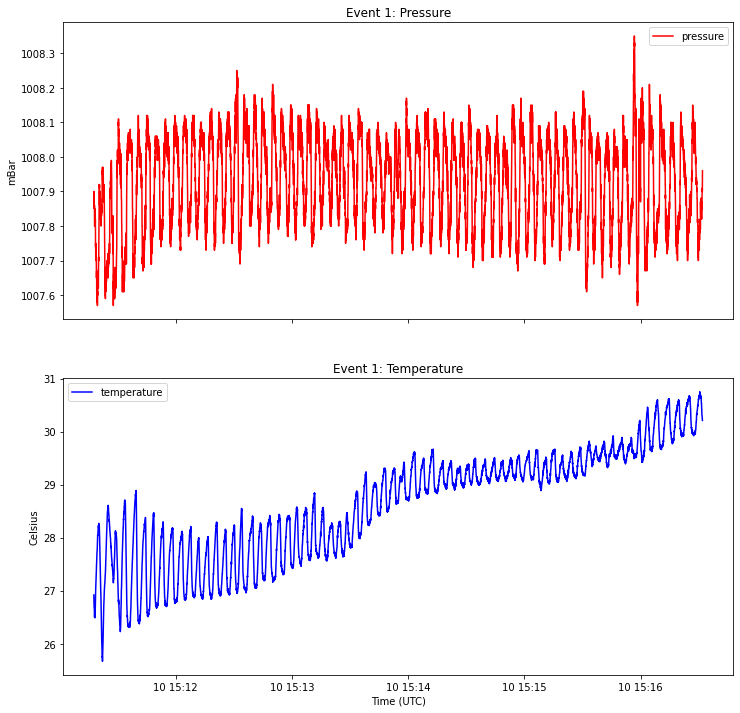

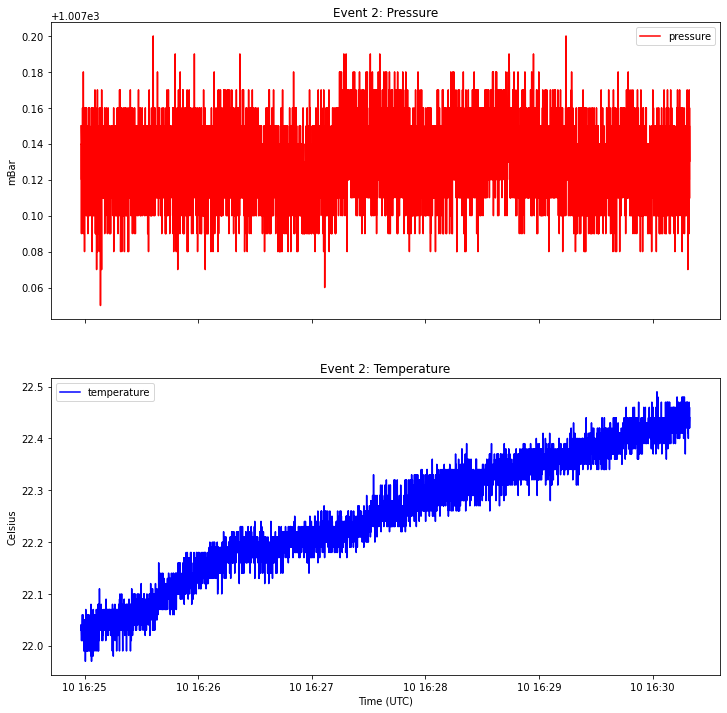

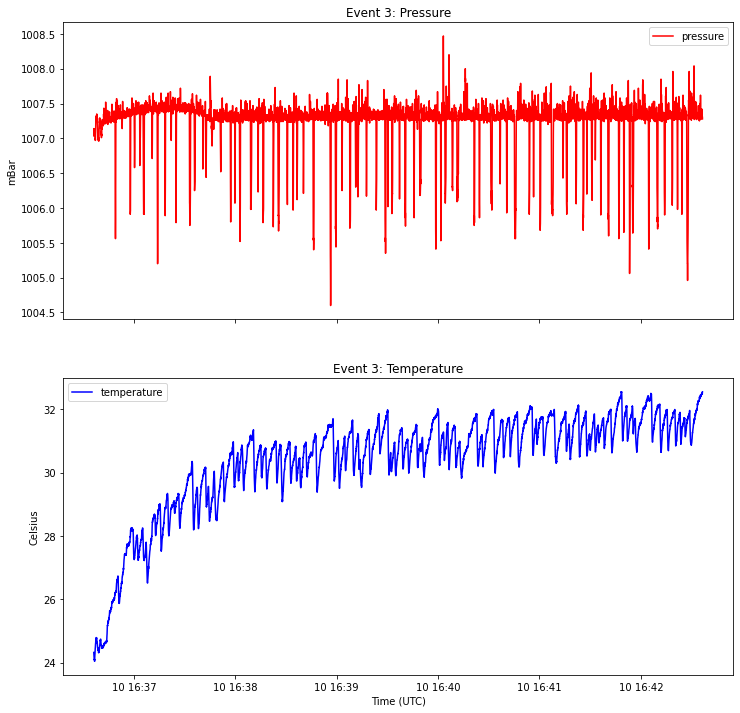

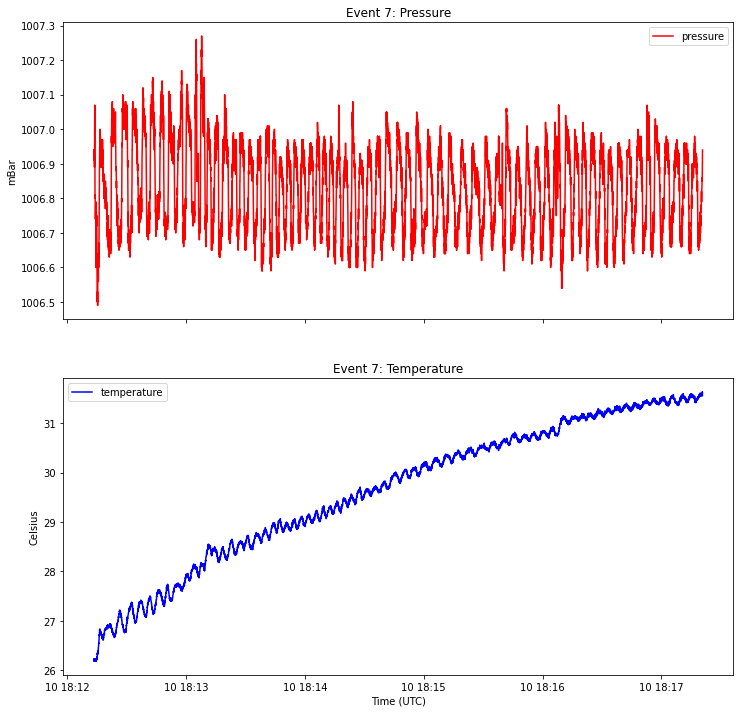

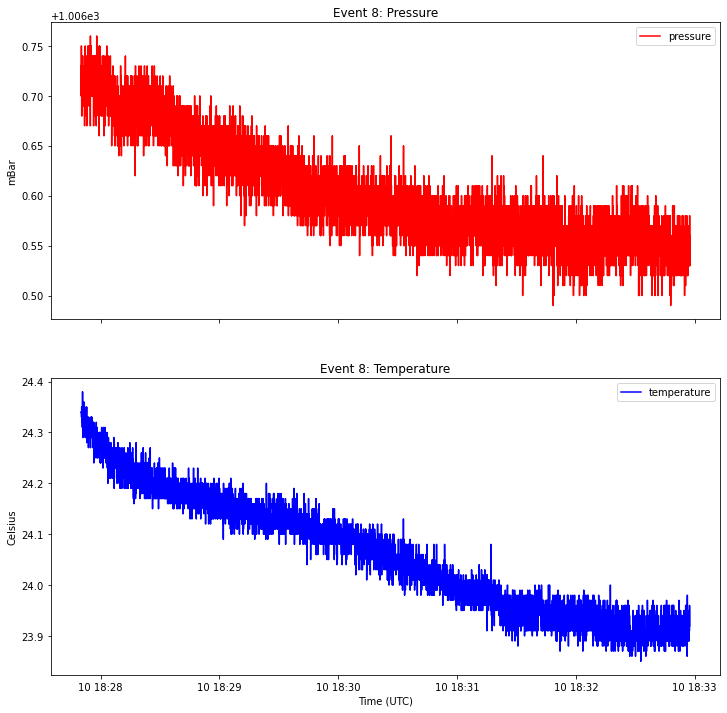

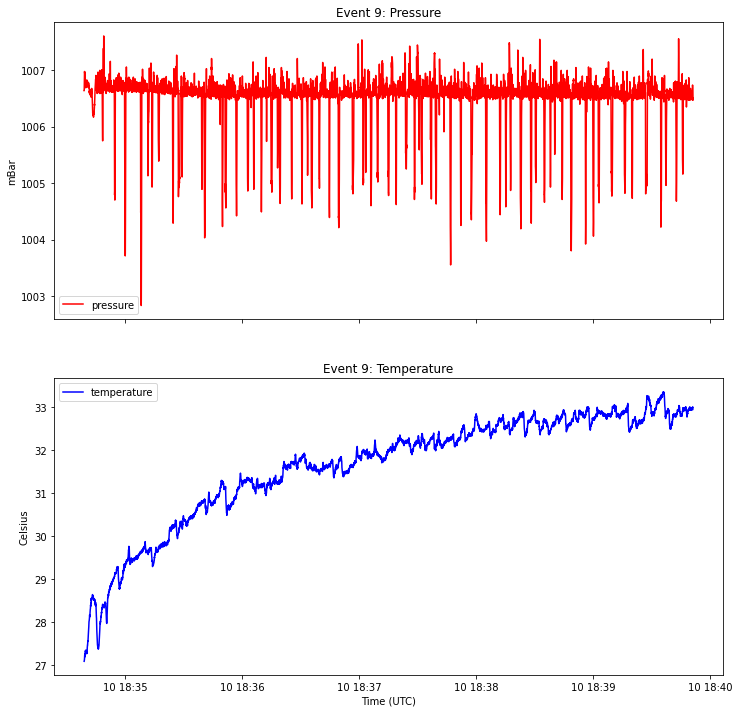

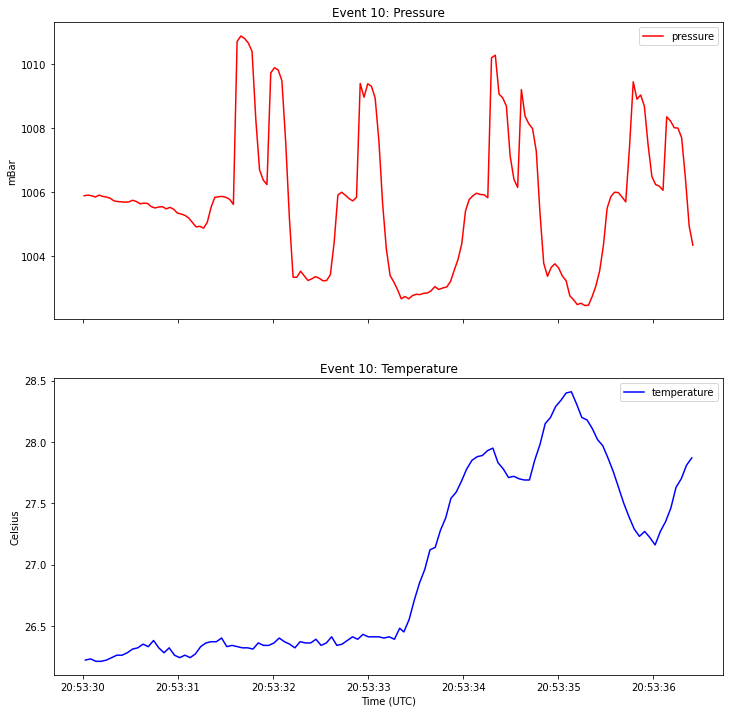

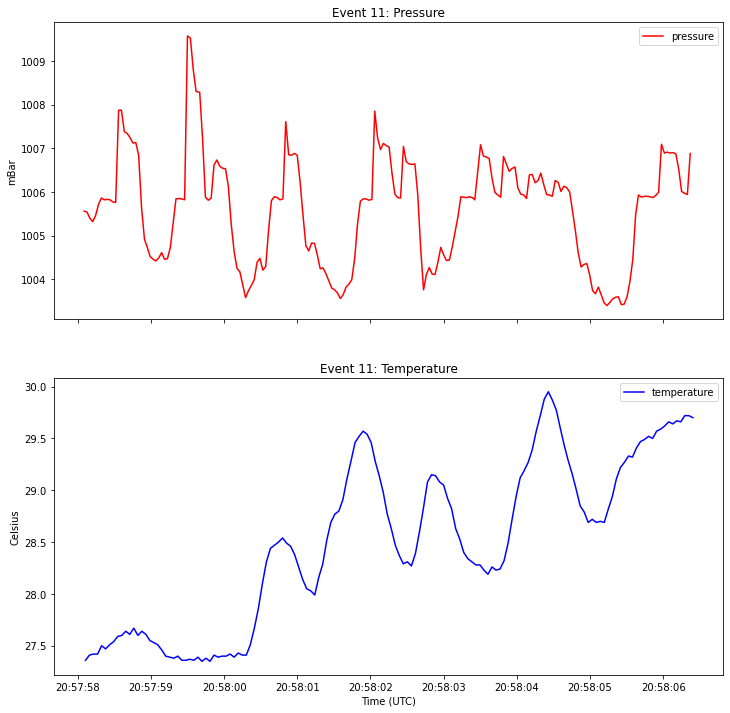

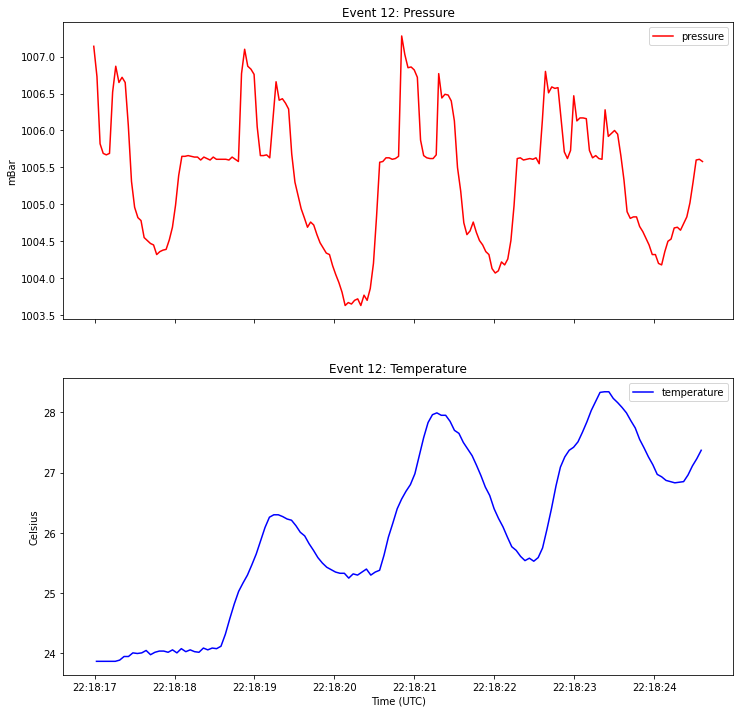

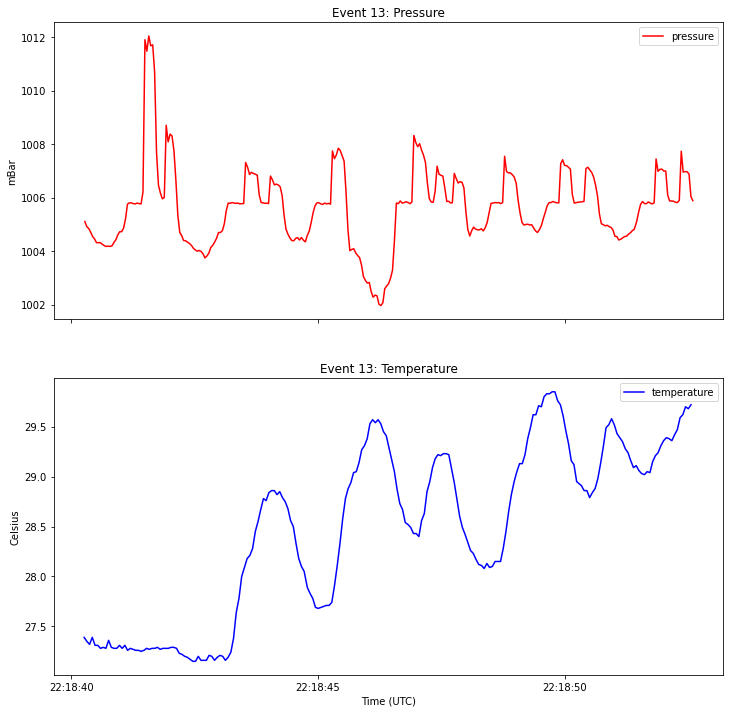

In [3]:
read_events(conn)

In [18]:
# split data

resample_freq = 17
test_split = 0.3

for file_idx, file in enumerate(os.listdir('events')):
    print(file)

    if file.split('.')[-1] != 'csv': continue
    
    df = pd.read_csv(f'events/{file}')
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

    event_type = df.iloc[0]['event_type']
    start_time = df.iloc[0]['start_time']

    df_temp = df.where(df['type'] == 'temperature').dropna().sort_values(by=['date'], ascending=True)
    df_pressure = df.where(df['type'] == 'pressure').dropna().sort_values(by=['date'], ascending=True)

    # resample based on timestamps
    period = f'{(1.0/resample_freq) * 1000:.2f}ms'
    # print(f'period: {period}')
    df_temp = df_temp.resample(period, on='date').mean()
    df_pressure = df_pressure.resample(period, on='date').mean()
    # if len(df_temp) != len(df_pressure): continue

    # df_temp.to_csv('temp.csv')
    # df_pressure.to_csv('pressure.csv')

    # convert to numpy array (signal)
    temp_sig = df_temp['value'].to_numpy()
    pressure_sig = df_pressure['value'].to_numpy()

    samples = []
    window = int(resample_freq * 3) # 3 sec
    stride = int(resample_freq) # 1 sec
    for i in range(0, len(temp_sig)-window, stride):
        t = temp_sig[i:i+window]
        p = pressure_sig[i:i+window]
        if len(t) == len(p):
            samples.append(np.vstack((t,p)))

    samples = np.array(samples)
    np.random.shuffle(samples)
    
    split_idx = int(len(samples) * test_split)
    test_samples = samples[:split_idx]
    train_samples = samples[split_idx:]

    print(train_samples.shape, test_samples.shape, event_type)
    
    np.save(f'data/test/{event_type}/s_{start_time}', test_samples)
    np.save(f'data/train/{event_type}/s_{start_time}', train_samples)
    
    





talking_2021-02-10 16:36:38.417000.csv
(251, 2, 51) (107, 2, 51) talking
normal_breathing_2_aaron_s.csv
(24, 2, 51) (10, 2, 51) normal_breathing
normal_breathing_3_aaron.csv
(25, 2, 51) (10, 2, 51) normal_breathing
cough_2021-02-10 20:53:33.741000.png
.DS_Store
talking_12_aaron.csv
(23, 2, 51) (9, 2, 51) talking
mask_off_2021-02-10 18:27:53.484000.csv
(214, 2, 51) (91, 2, 51) mask_off
normal_breathing_5_aaron.csv
(26, 2, 51) (11, 2, 51) normal_breathing
talking_12_aaron_s.csv
(26, 2, 51) (11, 2, 51) talking
talking_11_aaron_s.csv
(24, 2, 51) (10, 2, 51) talking
talking_2021-02-10 18:34:39.763000.csv
(217, 2, 51) (93, 2, 51) talking
cough_2021-02-10 20:57:59.617000.csv
(5, 2, 51) (1, 2, 51) cough
cough_2021-02-10 22:18:44.719000.png
normal_breathing_4_aaron_s.csv
(24, 2, 51) (10, 2, 51) normal_breathing
normal_breathing_2_aaron.csv
(24, 2, 51) (10, 2, 51) normal_breathing
talking_13_aaron.csv
(24, 2, 51) (10, 2, 51) talking
cough_2021-02-10 22:18:17.501000.png
normal_breathing_2021-02-1